# Probing folk wisdom

## Setup

In [8]:
'Notebooks is ready.'

'Notebooks is ready.'

In [2]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import sys
sys.path.insert(0, os.path.abspath('../..'))
# import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import collections
import pandas as pd

import utils.references as refs
from utils.acts_util import normalize
from utils.context_util import abbreviated_context as context_txt

In [175]:
import random
import nltk

In [4]:
# load corpus and acts
corpus_dir = '/atlas/u/pkalluri/bert-vis/big-data/wiki-large'
corpus_dir = os.path.abspath(corpus_dir)
corpus_contexts = pickle.load(open(os.path.join(corpus_dir, refs.contexts_fn),'rb'))
corpus_acts = np.load(os.path.join(corpus_dir, refs.acts_fn))
layers = corpus_acts.files

In [7]:
# get all tokens
corpus_toks = np.array([doc[pos] for doc, pos in corpus_contexts])
vocab = list(set(corpus_toks))
# corpus_txts = np.array([context_txt(doc,pos) for doc, pos in corpus_contexts])

## First, we probe for identity

In [172]:
def probe_identity(corpus_acts, corpus_contexts, corpus_filter, 
                   gaps=[-1,0,1], train_frac=.8, n_layers=None, predict_from_tok=False, verbose=False):
    n_layers = n_layers or len(corpus_acts)
    
    # calculate data filters
    acts_filters = {}
    contexts_filters = {}
    for gap in gaps:
        contexts_filter = []
        acts_filter = []
        for idx in corpus_filter:
            doc, pos = corpus_contexts[idx]
            if pos+gap in range(0, len(doc)):
                if predict_from_tok:
                    acts_filter.append(idx) # from tok
                    contexts_filter.append(idx+gap) # to my neighbors
                else:
                    acts_filter.append(idx+gap) # from neighbors
                    contexts_filter.append(idx)  # to tok
        acts_filters[gap] = acts_filter
        contexts_filters[gap] = contexts_filter
    for gap in gaps:
        if len(acts_filters[gap]) == 0:  # no contexts found
            del acts_filters[gap]
            del contexts_filters[gap]
    gaps = acts_filters.keys()
    
    # get target data
    corpus_toks = np.array([doc[pos] for doc, pos in corpus_contexts])
    target_toks = {gap: corpus_toks[contexts_filter] for gap, contexts_filter in contexts_filters.items()}
        
    model = LogisticRegression(max_iter=1000)
    scores = []
    for layer in layers[:n_layers]:
        if verbose: print(layer)
        _acts = corpus_acts[layer]
        for gap in gaps:
            if verbose: print('gap')
            _input_acts = _acts[acts_filters[gap]]
            _target_toks = target_toks[gap]
            n_train = int(train_frac * len(_input_acts))
            if verbose: print('fitting model...')
            model.fit(_input_acts[:n_train], _target_toks[:n_train])
            if verbose: print('calculating accuracy...')
            score = model.score(_input_acts[n_train:], _target_toks[n_train:])
            scores.append([layer,gap,score])
            if verbose: print(f'{layer}:{score}', flush=True)
    return pd.DataFrame(scores, columns=['layer','gap','score'])

In [152]:
def show_heatmap(scores, filter_name):
    fig = px.scatter(data_frame=scores[filter_name], x='gap', y='layer', size='score', color='score', size_max=10,
                color_continuous_scale=px.colors.sequential.Rainbow, title=f'Predicting {filter_name}')
    fig.update_layout(xaxis_dtick=1, yaxis_title=None, xaxis_title='Relative position', autosize=False, height=500, width=250)
    return fig

In [80]:
scores = {}

In [ ]:
filter_name = 'top toks'
selected_toks = list(zip(*collections.Counter(corpus_toks).most_common(100)))[0]
corpus_filter = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:1000]
scores[filter_name] = probe_identity(corpus_acts, corpus_contexts, corpus_filter, n_layers=None, gaps=range(-5,5))
show_heatmap(scores, filter_name)

/u/nlp/anaconda/main/anaconda3/envs/ria-bert-vis/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/u/nlp/anaconda/main/anaconda3/envs/ria-bert-vis/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

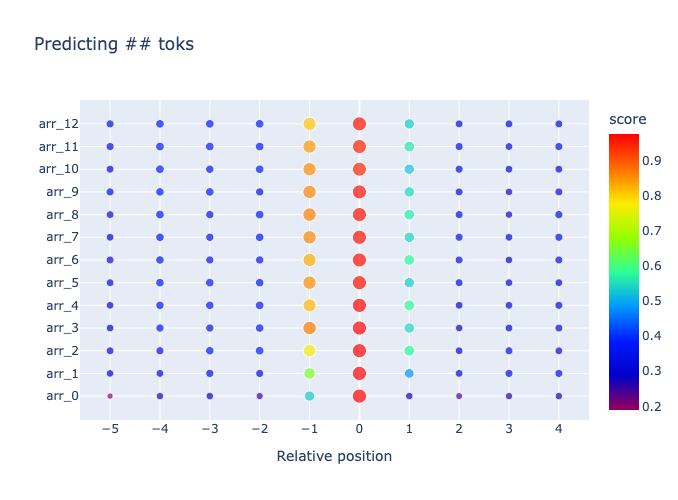

In [173]:
filter_name = '## toks'
selected_toks = [tok for tok in vocab if tok.startswith('##')][:100]
corpus_filter = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:1000]
scores[filter_name] = probe_identity(corpus_acts, corpus_contexts, corpus_filter, n_layers=None, gaps=list(range(-5,5)))
show_heatmap(scores, filter_name)

In [174]:
filter_name = 'random toks'
selected_toks = random.sample(vocab, 100)
corpus_filter = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:1000]
scores[filter_name] = probe_identity(corpus_acts, corpus_contexts, corpus_filter, n_layers=None, gaps=range(-5,5))
show_heatmap(scores, filter_name)

NameError: name 'random' is not defined

In [ ]:
filter_name = '\"car\"'
selected_toks = ['car']
corpus_filter = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:1000]
scores[filter_name] = probe_identity(corpus_acts, corpus_contexts, corpus_filter, n_layers=None, gaps=range(-5,5))
show_heatmap(scores, filter_name)

In [ ]:
def POS_tag(doc, pos): return nltk.pos_tag(toks)[position][1]

In [ ]:
filter_name = 'verbs'
corpus_filter = [i for i, context in enumerate(corpus_contexts) if POS_tag(*context)=='VB'][:1000]
scores[filter_name] = probe_identity(corpus_acts, corpus_contexts, corpus_filter, n_layers=None, gaps=range(-5,5))
show_heatmap(scores, filter_name)

In [ ]:
filter_name = 'nouns'
corpus_filter = [i for i, context in enumerate(corpus_contexts) if POS_tag(*context)=='NN'][:1000]
scores[filter_name] = probe_identity(corpus_acts, corpus_contexts, corpus_filter, n_layers=None, gaps=range(-5,5))
show_heatmap(scores, filter_name)

In [ ]:
filter_name = 'adjectives'
corpus_filter = [i for i, context in enumerate(corpus_contexts) if POS_tag(*context)=='JJ'][:1000]
scores[filter_name] = probe_identity(corpus_acts, corpus_contexts, corpus_filter, n_layers=None, gaps=range(-5,5))
show_heatmap(scores, filter_name)
